# LSTM Model for Cache Hit Prediction

This notebook implements a Long Short-Term Memory (LSTM) neural network to predict cache hits based on memory access patterns. The model analyzes sequences of memory addresses to learn patterns that indicate whether a future memory access will result in a cache hit or miss.

In [1]:
# PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# NumPy for numerical operations
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt

# PyTorch data utilities
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Advanced dictionary for counting and aggregation
from collections import defaultdict

from tqdm.auto import tqdm

import matplot2tikz

from torchmetrics import Accuracy, AveragePrecision, Recall, ConfusionMatrix

## Imports

Importing the necessary libraries:
- `torch` and `torch.nn`: PyTorch deep learning framework
- `numpy`: For numerical operations
- `matplotlib.pyplot`: For plotting and visualization
- `DataLoader` and `TensorDataset`: For batching and dataset handling
- `defaultdict`: For advanced dictionary operations

In [2]:
# Open the trace file containing memory access data
with open("test_red.out") as f:
    addrs = f.readlines()

# Split each line into hit/miss indicator and memory address
# The format is: 'hit_count memory_address'
hits, addrs = zip(*(l.rstrip().split(' ') for l in addrs))

# Convert hit counts to integers
hits = [int(hit) for hit in hits]

# Convert memory addresses from hex to integers
addrs = [int(addr, 16) for addr in addrs]

## Data Loading

Loading the cache access data from a file. Each line contains:
- A hit/miss indicator (1 for hit, 0 for miss)
- A memory address in hexadecimal format

In [3]:
hits[:10], addrs[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [536870744,
  536870752,
  805385384,
  805385392,
  805385376,
  805385400,
  536870728,
  536870720,
  536870712,
  536870704])

In [4]:
class AddrDataset(Dataset):
    def __init__(self, addresses, hits, seq_length):
        self.addresses = np.asarray(addresses)
        unique_addrs = np.unique(self.addresses)
        self.num_classes = len(unique_addrs)
        self.addr_to_index = {addr: i for i, addr in enumerate(unique_addrs)}
        self.hits = torch.tensor(np.asarray(hits) > 0).float()
        self.seq_length = seq_length

    def __len__(self):
        return len(self.addresses) - self.seq_length - 1 - 1

    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self) - idx
        addrs = self.addresses[idx:idx + self.seq_length]
        one_hot_x = torch.stack([F.one_hot(torch.tensor(self.addr_to_index[addr]), num_classes=self.num_classes).float() for addr in addrs])
        # index_x = torch.stack([torch.tensor(self.addr_to_index[addr]).float() for addr in addrs])
        label = self.hits[idx + self.seq_length]
        return one_hot_x, label.unsqueeze(0)

    def __repr__(self) -> str:
        return f"AddrDataset({self.num_classes=})"

dataset = AddrDataset(addrs, hits, 15)
dataset
(dataset[0], dataset[-1])

((tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([0.])),
 (tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([0.])))

In [5]:
# Check if CUDA-compatible GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Device Configuration

Setting up the computation device - will use GPU (CUDA) if available, otherwise CPU.

## LSTM Model Definition

Defining the Long Short-Term Memory (LSTM) neural network architecture:

- **Input**: Sequences of normalized memory addresses
- **LSTM Layer**: Processes sequences and captures temporal patterns
- **Fully Connected Layer**: Maps LSTM output to binary prediction

The model maintains and updates hidden state (h) and cell state (c) between batches for continuous learning on sequential data.

In [6]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, layer_dim, output_dim):
        '''
        Initialize the LSTM model.
        
        Parameters:
            input_dim (int): Size of input feature dimension (number of unique addresses for one-hot encoding)
            hidden_dim (int): Size of the hidden state
            layer_dim (int): Number of LSTM layers
            output_dim (int): Size of output (1 for binary prediction)
        '''
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Linear(input_dim, embedding_dim)

        #self.relu = nn.ReLU()
        
        # LSTM layer with batch_first=True means input shape is [batch, seq, feature]
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Fully connected layer to produce output prediction
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, h0=None, c0=None):
        '''
        Forward pass through the network.
        
        Parameters:
            x (tensor): Input tensor of shape [batch_size, seq_len, input_dim]
            h0 (tensor, optional): Initial hidden state
            c0 (tensor, optional): Initial cell state
            
        Returns:
            out (tensor): Output predictions
            hn (tensor): Final hidden state
            cn (tensor): Final cell state
        '''
        # Initialize hidden states if not provided
        if h0 is None or c0 is None:
            # Create zero tensors for hidden and cell states
            # Shape: [num_layers, batch_size, hidden_dim]
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out = self.embedding(x)
        
        # Forward propagate the LSTM
        # out shape: [batch_size, seq_len, hidden_dim]
        # hn and cn shape: [num_layers, batch_size, hidden_dim]
        out, (hn, cn) = self.lstm(out, (h0, c0))
        
        # Decode the hidden state of the last time step
        # Only take the output from the final timestep
        out = self.fc(out[:, -1, :])
        
        return self.sigmoid(out), hn, cn

In [7]:
#all_X = torch.cat([x_batch for x_batch, y_batch in train_dl], dim=0)
#X_mean = all_X.mean()
#X_std = all_X.std()

In [37]:
# Set batch size for training
# Larger batch size can speed up training but requires more memory
batch_size = 2048

# Create DataLoader for batch processing
# - shuffle=True: Randomizes data order in each epoch
# - drop_last=True: Drops the last incomplete batch
train_ds, test_ds = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)

## Model Initialization

Initializing the LSTM model with the following configuration:
- Input dimension: num_features (number of unique memory addresses for one-hot encoding)
- Hidden dimension: 100 (size of LSTM cell state)
- Layer dimension: 1 (single LSTM layer)
- Output dimension: 1 (binary prediction)

The one-hot encoding increases the input dimension but allows the model to distinguish between individual memory addresses more effectively.

Also configuring the loss function (Mean Squared Error) and optimizer (Adam).

In [38]:
# Get the number of features (dimension of one-hot encoded vectors)
num_features = dataset.num_classes  # The length of each one-hot encoded vector

# Initialize the LSTM model
# - input_dim=num_features: Each timestep has a one-hot encoded vector as feature
# - hidden_dim=100: Size of the hidden state vector
# - layer_dim=1: Single LSTM layer
# - output_dim=1: Binary output (hit probability)
model = LSTMModel(input_dim=num_features, embedding_dim=128, hidden_dim=100, layer_dim=1, output_dim=1).to(device)

# Define loss function - Mean Squared Error
criterion = nn.MSELoss()

# Define optimizer - Adam with learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## DataLoader Configuration

Preparing the data for batch processing using PyTorch's DataLoader:
- Creates a TensorDataset from input sequences and target values
- Configures the batch size, shuffling, and other training parameters

In [39]:
# Number of complete passes through the dataset
num_epochs = 6

inference_time = 0
total_infrences = 0

# Initialize hidden and cell states as None (will be created in first forward pass)
h0, c0 = None, None

history = defaultdict(list)

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    # Zero all gradients
    optimizer.zero_grad()

    # Process each batch in the dataset
    for i, batch in enumerate(train_dl):
        # Unpack inputs and targets from batch
        x_batch, y_batch = batch
        x_batch, y_batch = (x_batch.to(device), y_batch.to(device))

        start_time = time.time_ns()
        # Forward pass: compute predictions and get new hidden states
        outputs, h0, c0 = model(x_batch, h0, c0)
        
        # Calculate loss
        loss = criterion(outputs, y_batch)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters based on gradients
        optimizer.step()
        end_time = time.time_ns()
        
        inference_time += (end_time - start_time)
        total_infrences += x_batch.shape[0]

        # Calculate batch accuracy (threshold at 0.5 for binary classification)
        accuracy = ((outputs > 0.5) == y_batch).sum() / x_batch.shape[0]
    
        # Detach hidden states from the computation graph to prevent 
        # backpropagation through the entire history (avoids exploding gradients)
        h0 = h0.detach()
        c0 = c0.detach()

        history["loss"].append(loss.item())
        history["accuracy"].append(accuracy.item())
        
        # Print progress every 10 batches
        if i % 5 == 0:
            print(f"Epoch {epoch}, Batch {i}, Batch Loss: {loss.item():.4f}, Batch Accuracy {accuracy}")
    
    # Alternative epoch-level reporting (commented out)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch 0, Batch 0, Batch Loss: 0.2497, Batch Accuracy 0.51806640625
Epoch 0, Batch 5, Batch Loss: 0.2521, Batch Accuracy 0.4931640625
Epoch 0, Batch 10, Batch Loss: 0.2489, Batch Accuracy 0.51513671875
Epoch 0, Batch 15, Batch Loss: 0.2237, Batch Accuracy 0.673828125
Epoch 0, Batch 20, Batch Loss: 0.1857, Batch Accuracy 0.74462890625
Epoch 0, Batch 25, Batch Loss: 0.1989, Batch Accuracy 0.6689453125
Epoch 0, Batch 30, Batch Loss: 0.1334, Batch Accuracy 0.841796875
Epoch 0, Batch 35, Batch Loss: 0.1088, Batch Accuracy 0.8876953125
Epoch 1, Batch 0, Batch Loss: 0.0731, Batch Accuracy 0.92333984375
Epoch 1, Batch 5, Batch Loss: 0.0495, Batch Accuracy 0.93359375
Epoch 1, Batch 10, Batch Loss: 0.0418, Batch Accuracy 0.947265625
Epoch 1, Batch 15, Batch Loss: 0.0365, Batch Accuracy 0.9501953125
Epoch 1, Batch 20, Batch Loss: 0.0531, Batch Accuracy 0.91748046875
Epoch 1, Batch 25, Batch Loss: 0.0274, Batch Accuracy 0.96728515625
Epoch 1, Batch 30, Batch Loss: 0.0302, Batch Accuracy 0.961425781

In [40]:
inference_time / total_infrences

1121.9563489082532

## Model Training

Training the LSTM model with the following process:
1. Iterate through epochs
2. For each batch in the dataloader:
   - Forward pass through the model
   - Calculate accuracy and loss
   - Backward pass to compute gradients
   - Update model parameters

Note: The hidden and cell states are preserved between batches but detached from the computation graph to prevent exploding gradients.

In [34]:
# Example code for model evaluation (uncomment to use)
import time

inference_time = 0
total_infrences = 0

def evaluate_model(model, test_dl):
    global inference_time
    global total_infrences
    '''
    Evaluate the model on test data
    
    Parameters:
        model: Trained LSTM model
        X_test: Test input sequences with one-hot encoded addresses
        y_test: Test labels
    
    Returns:
        accuracy: Model accuracy on test data
    '''
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        h0, c0 = None, None
        batch_outputs = []
        true_outputs = []
        for i, batch in enumerate(test_dl):
            x_batch, y_batch = batch
            x_batch, y_batch = (x_batch.to(device), y_batch.to(device))

            start_time = time.time_ns()
            outputs, h0, c0 = model(x_batch, h0, c0)
            end_time = time.time_ns()
            inference_time += (end_time - start_time)
            total_infrences += x_batch.shape[0]

            batch_outputs.append(outputs)
            true_outputs.append(y_batch)
            #accuracy = ((outputs > 0.5) == y_batch).sum() / x_batch.shape[0]
            #batch_accuracies.append(accuracy)

    return torch.cat(batch_outputs, dim=0), torch.cat(true_outputs, dim=0)

outputs, true = evaluate_model(model, test_dl)

In [35]:
inference_time / total_infrences

334.03455946180554

In [12]:
outputs.shape, true.shape

(torch.Size([18432, 1]), torch.Size([18432, 1]))

In [13]:
true.int()

tensor([[1],
        [1],
        [0],
        ...,
        [0],
        [1],
        [1]], device='cuda:0', dtype=torch.int32)

In [14]:
acc = Accuracy(task="binary").to(device)(outputs, true).item()
print(f"{acc:.2%}")

98.19%


In [15]:
prec = AveragePrecision(task="binary").to(device)(outputs, true.int()).item()
print(f"{prec:.4}")

0.993


In [24]:
rec = Recall(task="binary").to(device)(outputs, true.int()).item()
print(f"{rec:.4}")

0.9848


In [17]:
confusion = ConfusionMatrix(task="binary").to(device)(outputs, true)
confusion

tensor([[9078,  195],
        [ 139, 9020]], device='cuda:0')

In [18]:
import seaborn as sns

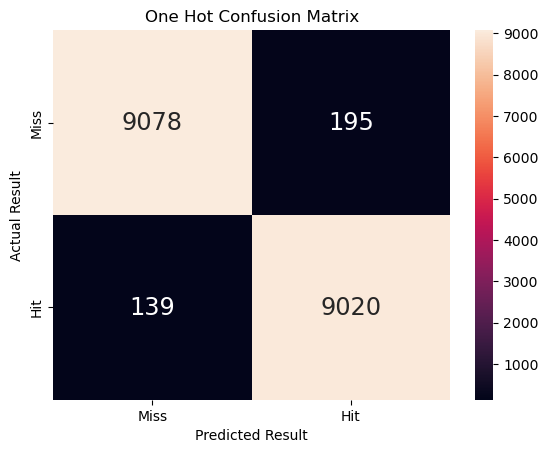

In [19]:
sns.heatmap(confusion.cpu(), xticklabels=["Miss", "Hit"], yticklabels=["Miss", "Hit"], annot=True, fmt=".10g", annot_kws={"fontsize": "xx-large"})
plt.title("One Hot Confusion Matrix")
plt.ylabel("Actual Result")
plt.xlabel("Predicted Result")
matplot2tikz.save("one-hot-confusion.tex")

In [20]:
outputs, true

(tensor([[9.9998e-01],
         [9.9999e-01],
         [2.8389e-05],
         ...,
         [5.0243e-06],
         [1.0000e+00],
         [7.8358e-01]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [0.],
         ...,
         [0.],
         [1.],
         [1.]], device='cuda:0'))

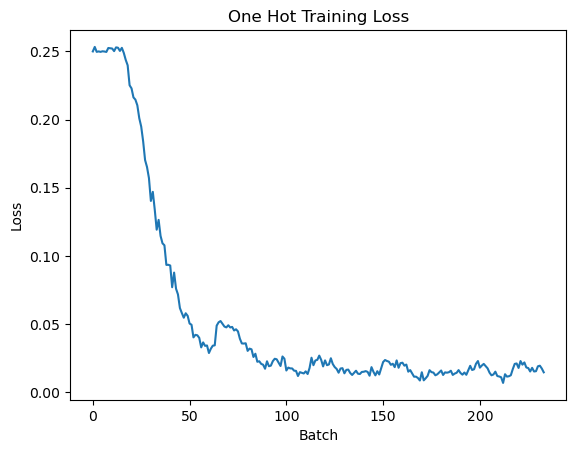

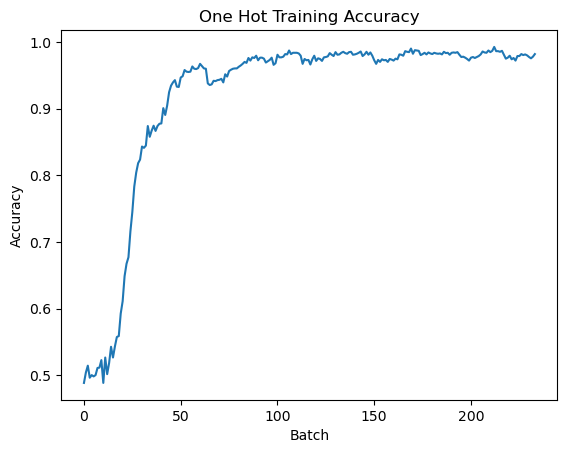

In [21]:
# Plot training history
def plot_training_history(history):
    '''
    Plot the training loss and accuracy over epochs
    
    Parameters:
        history: Dictionary containing 'loss' and 'accuracy' lists
    '''
    
    # Plot loss
    plt.plot(history['loss'])
    plt.title('One Hot Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    matplot2tikz.save("one-hot-training-loss.tex")
    plt.show()
    
    # Plot accuracy
    plt.plot(history['accuracy'])
    plt.title('One Hot Training Accuracy')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    matplot2tikz.save("one-hot-training-accuracy.tex")
    plt.show()

plot_training_history(history)

In [22]:
# # Function to visualize the one-hot encoded data
# def visualize_onehot_data(X, num_samples=5):
#     '''
#     Visualizes a few examples of one-hot encoded memory addresses
#     
#     Parameters:
#         X: One-hot encoded data
#         num_samples: Number of samples to visualize
#     '''
#     plt.figure(figsize=(10, 6))
#     for i in range(min(num_samples, len(X))):
#         plt.subplot(num_samples, 1, i+1)
#         plt.imshow(X[i].reshape(1, -1), aspect='auto', cmap='viridis')
#         plt.title(f"Sample {i+1}")
#         plt.ylabel("One-hot vector")
#     plt.tight_layout()
#     plt.show()

## Model Evaluation and Further Steps

After training, the model can be used to predict cache hits for new memory address sequences. Possible next steps:

1. **Model Evaluation**: Test the model on a separate validation set to assess generalization performance
2. **Hyperparameter Tuning**: Experiment with different LSTM configurations (hidden size, number of layers)
3. **Feature Engineering**: Consider additional features like program counter values
4. **Visualization**: Plot the training loss and accuracy curves
5. **Inference**: Use the trained model to predict cache behavior for new memory traces
6. **Encoding Optimization**: If the number of unique addresses is very large, consider dimensionality reduction techniques or address clustering to reduce the one-hot vector size
7. **Memory Efficiency**: For extremely large address spaces, explore memory-efficient alternatives to one-hot encoding, such as embedding layers that learn dense representations of addresses

## Memory Considerations for One-Hot Encoding

One-hot encoding provides clear separation between different memory addresses, which can improve model learning. However, it comes with memory trade-offs:

**Advantages:**
- Treats each address as a distinct entity
- Avoids imposing an artificial numerical relationship between addresses
- May capture patterns that normalized values would miss

**Challenges:**
- High dimensionality with large address spaces (potentially millions of unique addresses)
- Sparse representation (mostly zeros) requiring more memory
- May need dimensionality reduction for very large address spaces

**Possible Solutions:**
- Address bucketing: Group similar addresses into buckets
- Page-level encoding: Encode at page granularity instead of exact addresses
- Embedding layers: Learn dense representations of addresses
- Feature hashing: Map addresses to a smaller feature space

In [23]:
# Example of more memory-efficient alternatives to full one-hot encoding
# Uncomment and modify as needed

# Option 1: Address bucketing - group addresses into a smaller number of buckets
# def create_address_buckets(addresses, num_buckets=1000):
#     min_addr = min(addresses)
#     max_addr = max(addresses)
#     bucket_size = (max_addr - min_addr) / num_buckets
#     
#     # Assign each address to a bucket
#     buckets = []
#     for addr in addresses:
#         bucket = int((addr - min_addr) / bucket_size)
#         buckets.append(min(bucket, num_buckets-1))  # Cap at max bucket
#         
#     # One-hot encode the buckets instead of raw addresses
#     bucket_onehot = np.zeros((len(buckets), num_buckets))
#     for i, bucket in enumerate(buckets):
#         bucket_onehot[i, bucket] = 1
#         
#     return bucket_onehot

# Option 2: Embedding layer approach - learn dense vector representations
# class EmbeddingLSTMModel(nn.Module):
#     def __init__(self, num_addresses, embedding_dim, hidden_dim, layer_dim, output_dim):
#         super(EmbeddingLSTMModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim
#         
#         # Embedding layer converts address indices to dense vectors
#         self.embedding = nn.Embedding(num_addresses, embedding_dim)
#         
#         # LSTM layer
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, layer_dim, batch_first=True)
#         
#         # Fully connected layer
#         self.fc = nn.Linear(hidden_dim, output_dim)
#     
#     def forward(self, x, h0=None, c0=None):
#         # Convert address indices to embeddings
#         # x shape: [batch_size, seq_len] -> [batch_size, seq_len, embedding_dim]
#         embedded = self.embedding(x)
#         
#         # Initialize hidden states if not provided
#         if h0 is None or c0 is None:
#             h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
#             c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
#         
#         # Forward propagate LSTM
#         out, (hn, cn) = self.lstm(embedded, (h0, c0))
#         
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         
#         return out, hn, cn